In [18]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import os
from numba import cuda 
from matplotlib.pyplot import cm



plt.style.use("science.mplstyle")

dpi = 800


In [23]:
results_dir = "/clusterfs/ml4hep/rrmastandrea/oversampling_results/"

n_sig_inj = [1000]
seeds = [x for x in range(1)]



# Load in


In [24]:
def get_sic_rejection(idd, seed, n):
    
    loc_dir = f"{results_dir}/nsig_inj{n}_seed1/"
    
    path_to_fpr = f"{loc_dir}/fpr_{idd}_{seed}.npy"
    path_to_tpr = f"{loc_dir}/tpr_{idd}_{seed}.npy"
   
    fpr = np.load(path_to_fpr)
    tpr = np.load(path_to_tpr)
    
    # get the nonzero entries of fpr
    fpr_nonzero_indices = np.where(fpr != 0)
    fpr_nonzero = fpr[fpr_nonzero_indices]
    tpr_nonzero = tpr[fpr_nonzero_indices]

    rejection = 1.0 / fpr_nonzero #np.divide(1.0, fpr, out=np.zeros_like(fpr), where=fpr!=0)
    sic = tpr_nonzero / np.sqrt(fpr_nonzero) #np.divide(tpr, np.sqrt(fpr), out=np.zeros_like(tpr), where=np.sqrt(fpr)!=0)
    
    
    return tpr_nonzero, sic, rejection


x_axis = np.logspace(-8, 0, 400)


keys = [x for x in range(0, 7)]


rejections_dict = {k:{n:[] for n in n_sig_inj} for k in keys}     
sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
max_sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}


for n in n_sig_inj:
    
    for seed in seeds:
        
        for k in keys:

            
            if k == 0:
                iid = "feta"
            else:
                iid = f"feta_o{k}"

            tpr, sic, rejection = get_sic_rejection(iid, seed, n)    
            
            interp_sic = np.interp(x_axis, tpr, sic)
            interp_rej = np.interp(x_axis, tpr, rejection)
            rejections_dict[k][n].append(interp_rej)
            sics_dict[k][n].append(interp_sic)
            max_sics_dict[k][n].append(np.nanmax(sic[np.isfinite(sic)]))
            

# Take the avg

In [25]:
def get_mean_std(loc_list):
    
    mean = np.nanmedian(loc_list, axis = 0)
    std = np.nanstd(loc_list, axis = 0)
    
    return mean, std

mean_rejections_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
mean_sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
mean_max_sics_dict = {k:[[],[]] for k in keys} # mean, stf
    
   

for n in n_sig_inj:
    
    for k in keys:
        
        mean_rejections_dict[k][n] = get_mean_std(rejections_dict[k][n])
        mean_sics_dict[k][n] = get_mean_std(sics_dict[k][n])
        mean_max_sics_dict[k][0].append(np.median(max_sics_dict[k][n]))
        mean_max_sics_dict[k][1].append(np.std(max_sics_dict[k][n]))
        

for k in keys:
    mean_max_sics_dict[k][0] = np.array(mean_max_sics_dict[k][0])
    mean_max_sics_dict[k][1] = np.array(mean_max_sics_dict[k][1])
    


In [26]:
n_to_plot = [1000]


l = 3
f_1 = 20
f_2 = 30

# SIC

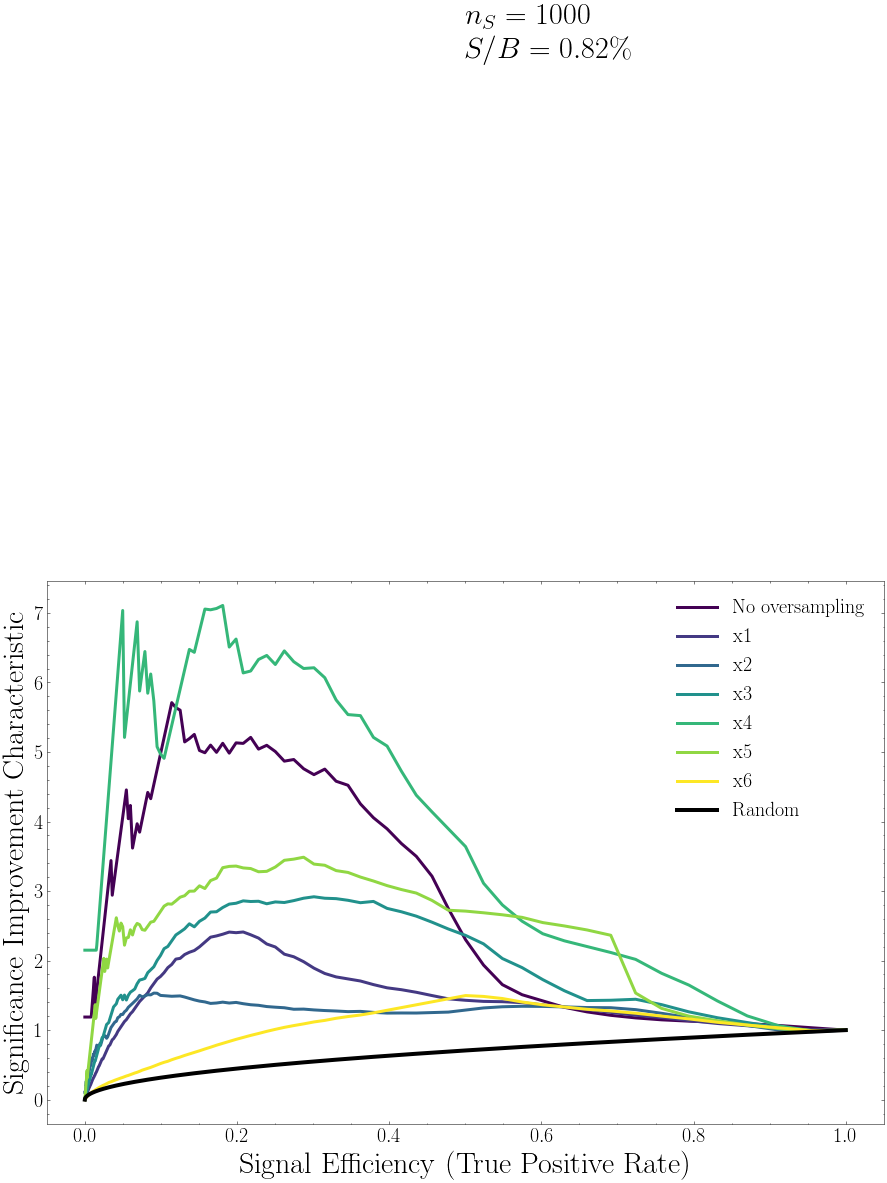

In [29]:
color = iter(cm.viridis(np.linspace(0, 1, 7)))

for n in n_to_plot:
    fig = plt.figure(figsize = (15, 10))

    for k in range(0, 7):
        c = next(color)
        if k == 0:
            label = "No oversampling"
        else: 
            label = f"x{k}"
        
        plt.plot(x_axis, mean_sics_dict[k][n][0], label = label, color = c, linewidth = l)

        plt.fill_between(x_axis, mean_sics_dict[k][n][0] - mean_sics_dict[k][n][1],
                         mean_sics_dict[k][n][0] + mean_sics_dict[k][n][1],
                         alpha = 0.5, color = c, linewidth = 0)
  

    plt.plot(x_axis, x_axis/np.sqrt(x_axis), label = "Random", color = "black", linewidth = l+1)
    
    plt.text(0.5, 15, f"$n_S = {n}$\n$S/B = {np.round(100*n/num_bkg, 2)}\%$", fontsize = f_2)

    plt.legend(fontsize = f_1)
    plt.xlabel("Signal Efficiency (True Positive Rate)", fontsize = f_2)    
    plt.ylabel("Significance Improvement Characteristic", fontsize = f_2)
    plt.tick_params(axis='both', which='major', labelsize=f_1)
    #plt.title(f"Num injected events: {n}")
    
    fig.savefig(f"paper_plots/sic_{n}.png", dpi = dpi)
    
    plt.show()

# Rejection

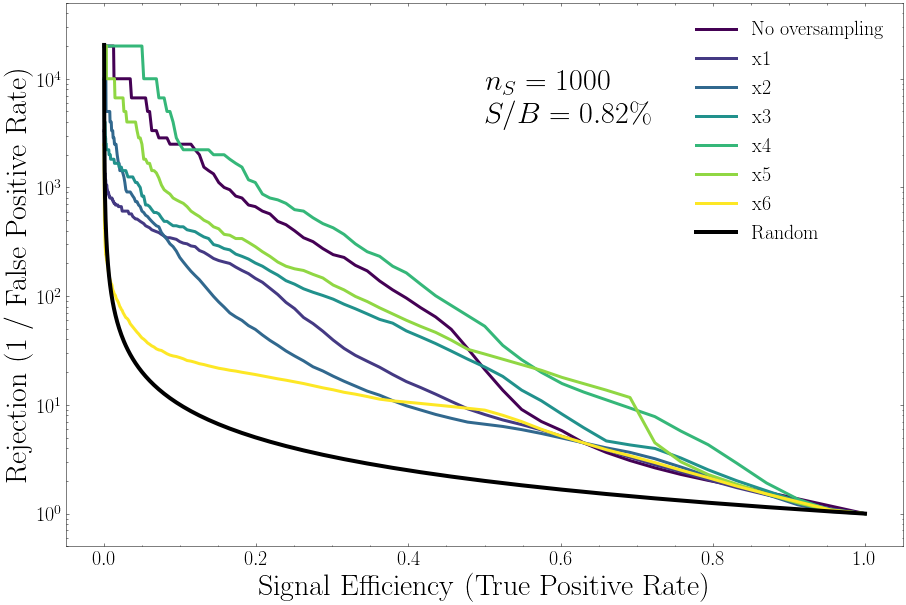

In [32]:
color = iter(cm.viridis(np.linspace(0, 1, 7)))

for n in n_to_plot:
    fig = plt.figure(figsize = (15, 10))

    for k in range(0, 7):
        c = next(color)
        if k == 0:
            label = "No oversampling"
        else: 
            label = f"x{k}"
            
        plt.plot(x_axis, mean_rejections_dict[k][n][0], label = label, color = c, linewidth = l)

        plt.fill_between(x_axis, mean_rejections_dict[k][n][0] - mean_rejections_dict[k][n][1],
                         mean_rejections_dict[k][n][0] + mean_rejections_dict[k][n][1],
                         alpha = 0.5, color = c, linewidth = 0)

    plt.plot(x_axis[184:], 1.0/x_axis[184:], label = "Random", color = "black", linewidth = l+1)
    
    plt.text(0.5, 4000, f"$n_S = {n}$\n$S/B = {np.round(100*n/num_bkg, 2)}\%$", fontsize = f_2)

    plt.legend(fontsize = f_1)  
    plt.ylim(5e-1, 5e4)
    plt.yscale("log")
    plt.xlabel("Signal Efficiency (True Positive Rate)", fontsize = f_2)  
    plt.ylabel("Rejection (1 / False Positive Rate)", fontsize = f_2)  
    #plt.title(f"Num injected events: {n}")
    plt.tick_params(axis='both', which='major', labelsize=f_1)
    
    fig.savefig(f"paper_plots/rej_{n}.png", dpi = dpi)

    plt.show()

## SIC vs rej

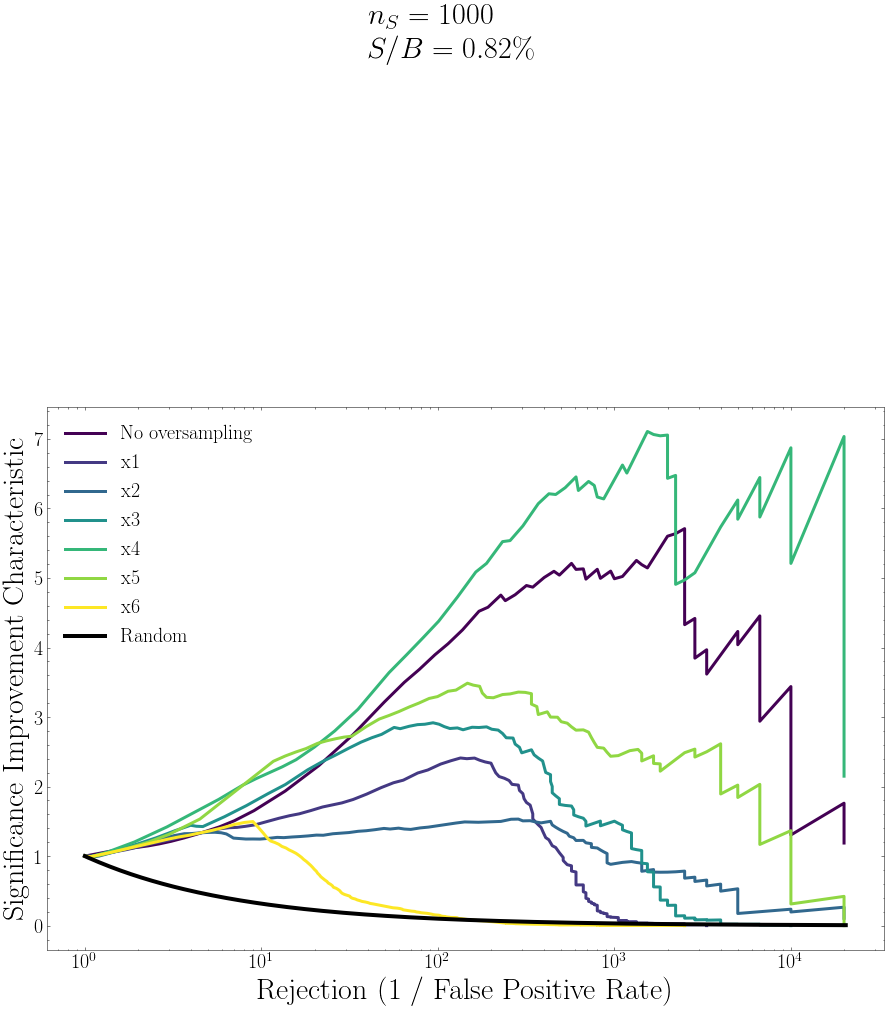

In [33]:
color = iter(cm.viridis(np.linspace(0, 1, 7)))

for n in n_to_plot:
    fig = plt.figure(figsize = (15, 10))

    for k in range(0, 7):
        c = next(color)
        if k == 0:
            label = "No oversampling"
        else: 
            label = f"x{k}"
            
            
        plt.plot(mean_rejections_dict[k][n][0], mean_sics_dict[k][n][0], label = label, color = c, linewidth = l)

        plt.fill_between(mean_rejections_dict[k][n][0], mean_sics_dict[k][n][0] - mean_sics_dict[k][n][1],
                         mean_sics_dict[k][n][0] + mean_sics_dict[k][n][1],
                         alpha = 0.5, color = c, linewidth = 0)

    plt.plot(1.0/x_axis[184:], x_axis[184:]/np.sqrt(x_axis[184:]), label = "Random", color = "black", linewidth = l+1)
    
    plt.text(40, 12.5, f"$n_S = {n}$\n$S/B = {np.round(100*n/num_bkg, 2)}\%$", fontsize = f_2)
    plt.legend(fontsize = f_1)
    plt.xscale("log")
    plt.xlabel("Rejection (1 / False Positive Rate)", fontsize = f_2)  
    plt.ylabel("Significance Improvement Characteristic", fontsize = f_2)
    #plt.title(f"Num injected events: {n}")
    plt.tick_params(axis='both', which='major', labelsize=f_1)
    fig.savefig(f"paper_plots/sic_vs_rej_{n}.png", dpi = dpi)
    


    plt.show()

In [14]:
num_bkg = 121339

x_vals = [n / num_bkg for n in n_sig_inj]



fig = plt.figure(figsize = (15, 10)) 

for k in keys:

    plt.plot(x_vals, mean_max_sics_dict[k][0], label = labels_dict[k], color = colors_dict[k], linewidth = l)

    plt.fill_between(x_vals, mean_max_sics_dict[k][0] -mean_max_sics_dict[k][1],
                        mean_max_sics_dict[k][0] + mean_max_sics_dict[k][1],
                         alpha = 0.5, color = colors_dict[k], linewidth = 0)
   

ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax2.set_xticks(n_sig_inj)
ax2.set_xticklabels(n_sig_inj, size=f_1, rotation = 45)
ax2.set_xlabel(r"$n_\mathrm{sig}$", fontsize = f_2, labelpad = 10)


ax1.set_xticks(x_vals)
ax1.set_xticklabels([f"{np.round(100*x, 2)}\%" for x in x_vals], size=f_1, rotation = 45)
ax1.set_xlabel("S/B", fontsize = f_2)

ax1.legend(fontsize = f_1, loc = "lower right")

ax1.set_ylabel("max(SIC)", fontsize = f_2)
ax1.tick_params(axis='both', which='major', labelsize=f_1)
fig.savefig(f"paper_plots/maxsic.png", dpi = dpi)

plt.show()





NameError: name 'labels_dict' is not defined

<Figure size 1080x720 with 0 Axes>